# Tutorial 4: Human bone marrow (ATAC-seq + Protein Epitopes)

Tutorials 4 and 5 study a human bone marrow dataset by [Mimitou et al., 2021](https://www.nature.com/articles/s41587-021-00927-2) showing the differentiation of hematopoietic stem cells to multiple developmental fates.

## Loading and preprocessing data

The dataset has two modalities: chromatin accessibility (ATAC-seq) and protein epitopes. Raw data is available on [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156478). For analyses, we use count matrices filtered by the dataset authors from [here](https://github.com/caleblareau/asap_reproducibility/tree/master/bonemarow_asapseq/output/for_total_vi_asap_marrow/filtered_feature_bc_matrix). We converted count matrices to the annotated h5ad format, available for download on [figshare](https://doi.org/10.6084/m9.figshare.22700062.v1).

Download annotated data.

In [1]:
! wget --content-disposition https://figshare.com/ndownloader/articles/22700062/versions/3
! unzip -o 22700062.zip
! rm 22700062.zip

--2023-10-05 11:24:35--  https://figshare.com/ndownloader/articles/22700062/versions/3
Resolving figshare.com (figshare.com)... 52.49.59.79, 34.248.41.179, 2a05:d018:1f4:d000:57ed:d715:14c4:2854, ...
Connecting to figshare.com (figshare.com)|52.49.59.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37581583 (36M) [application/zip]
Saving to: ‘22700062.zip’

22700062.zip        100%[===================>]  35.84M  13.8MB/s    in 2.6s    

2023-10-05 11:24:38 (13.8 MB/s) - ‘22700062.zip’ saved [37581583/37581583]

Archive:  22700062.zip
 extracting: human_bone_marrow_atac.h5ad  
 extracting: human_bone_marrow_atac_hscs.h5ad  
 extracting: human_bone_marrow_prot.h5ad  
 extracting: human_bone_marrow_prot_hscs.h5ad  


Load the chromatin accessibility annotated data and compute its LDA embedding. The ATAC-seq count matrix comprises 10,927 cells and 3,000 genes (achieved by mapping chromatin accessibility fragments to gene regions with [Signac](https://stuartlab.org/signac/index.html)). Loaded data includes 15 precomputed LDA topics. 

In [2]:
import anndata as ad
import ocelli as oci

atac = ad.read_h5ad('human_bone_marrow_atac.h5ad')

# compute LDA topics
# oci.pp.LDA(atac, n_components=15, max_iter=50, random_state=17, verbose=1)

atac

AnnData object with n_obs × n_vars = 10927 × 3000
    obs: 'celltype'
    var: 'modality'
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'

Repeat for protein epitopes data consisting of 238 protein tags. Loaded data includes 15 precomputed LDA topics. 

In [3]:
prot = ad.read_h5ad('human_bone_marrow_prot.h5ad')

# compute LDA topics
# oci.pp.LDA(prot, n_components=15, max_iter=50, random_state=17, verbose=1)

prot

AnnData object with n_obs × n_vars = 10927 × 238
    obs: 'celltype'
    var: 'modality'
    uns: 'X_lda_params'
    obsm: 'X_lda'
    varm: 'X_lda'

## Multimodal Diffusion Maps

Create a joint AnnData object storing LDA embeddings of both modalities. Annotated data must include processed modality matrices (in `adata.obsm`) and a list of their keys (in `adata.uns`).

In [4]:
from scipy.sparse import csr_matrix

# create empty AnnData object
adata = ad.AnnData(csr_matrix(([],([],[])), shape=(10927, 1)))

# save modality arrays
adata.obsm['atac'] = atac.obsm['X_lda']
adata.obsm['prot'] = prot.obsm['X_lda']
adata.uns['modalities'] = ['atac', 'prot']

# save cell metadata
adata.obs.index = list(atac.obs.index)
adata.obs['celltype'] = list(atac.obs['celltype'])

adata

AnnData object with n_obs × n_vars = 10927 × 1
    obs: 'celltype'
    uns: 'modalities'
    obsm: 'atac', 'prot'

Run MDM to find a multimodal representation of the dataset. Follow a three-step process from previous tutorials:

* find nearest neighbors across all modalities,
* calculate multimodal weights,
* and compute the MDM embedding.

In [5]:
oci.pp.neighbors(adata, n_neighbors=70, verbose=True)
oci.tl.weights(adata, random_state=17, verbose=True)
oci.tl.MDM(adata, n_components=10, random_state=17, verbose=True)

[atac]	70 nearest neighbors calculated.
[prot]	70 nearest neighbors calculated.


2023-10-05 11:24:50,002	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2023-10-05 11:24:56,148	INFO worker.py:1518 -- Started a local Ray instance.


[atac]	Unimodal Markov chain calculated.
[prot]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


## Visualizing MDM components

Create a nearest-neighbors graph in the MDM latent space and visualize it with ForceAtlas2.

In [6]:
oci.pp.neighbors(adata, x=['X_mdm'], n_neighbors=20, verbose=True)
oci.tl.neighbors_graph(adata, x='X_mdm', n_edges=20, verbose=True)
oci.tl.FA2(adata, n_components=2, random_state=142, n_iter=20000,
           linlogmode=True, flags='--jitterTolerance 0.1 --scalingRatio 0.01 '\
           '--outboundAttractionDistribution true')

[X_mdm]	20 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Oct 05, 2023 11:25:24 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 05, 2023 11:25:26 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 10,927 (10,927 added)
Oct 05, 2023 11:25:26 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 218,540 (143,249 added)


***********

**************25%
*************************50%
*************************75%
*************************100%
Time = 296.482s


Plot the embedding.

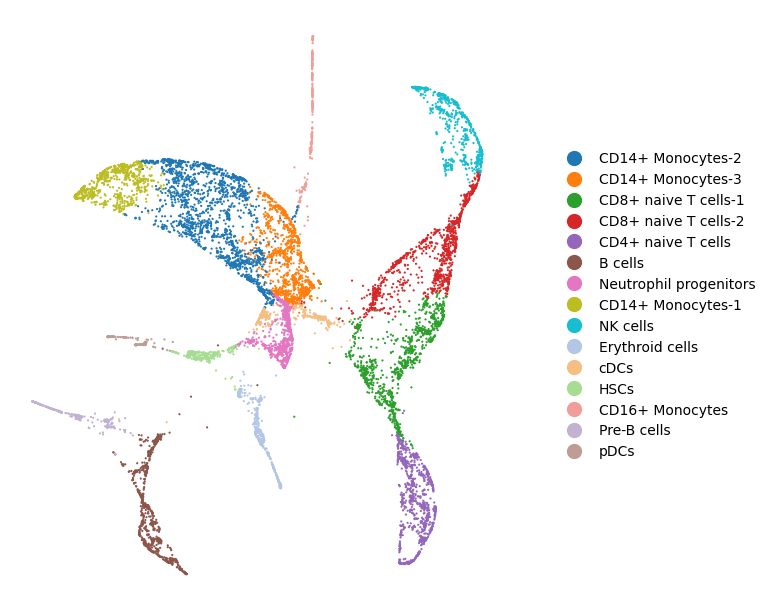

In [7]:
cdict = {'CD14+ Monocytes-2': '#1f77b4',
         'CD14+ Monocytes-3': '#ff7f0e',
         'CD8+ naive T cells-1': '#2ca02c',
         'CD8+ naive T cells-2': '#d62728',
         'CD4+ naive T cells': '#9467bd',
         'B cells': '#8c564b',
         'Neutrophil progenitors': '#e377c2',
         'CD14+ Monocytes-1': '#bcbd22',
         'NK cells': '#17becf',
         'Erythroid cells': '#b3c6e5',
         'cDCs': '#f5be82',
         'HSCs': '#a7dd93',
         'CD16+ Monocytes': '#f19d99',
         'Pre-B cells': '#c1b1d2',
         'pDCs': '#be9d96'}

oci.pl.scatter(adata, x='X_fa2', c='celltype', cdict=cdict, markersize=2.5, title='',
               fontsize=10, markerscale=2, figsize=(8, 6))

## Interpreting multimodal weights

Multimodal weight distribution shows that chromatin accessibility is more informative for:

* hematopoietic stem cells (HSCs),
* neutrophil progenitors,
* erythroid cells,
* plasmacytoid dendritic cells (pDCs).

Proteins are more informative for monocytes, T cells, or B cells.

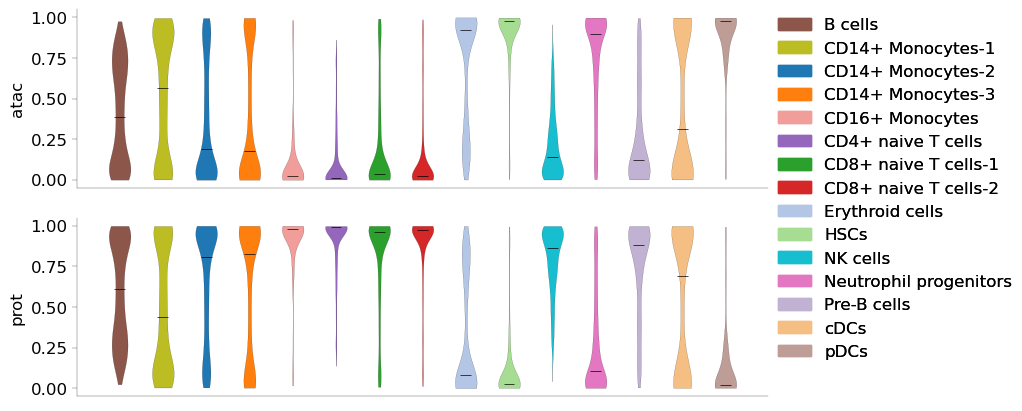

In [8]:
oci.pl.violin(adata, groups='celltype', values='weights', cdict=cdict, fontsize=12, 
              figsize=(10, 4))

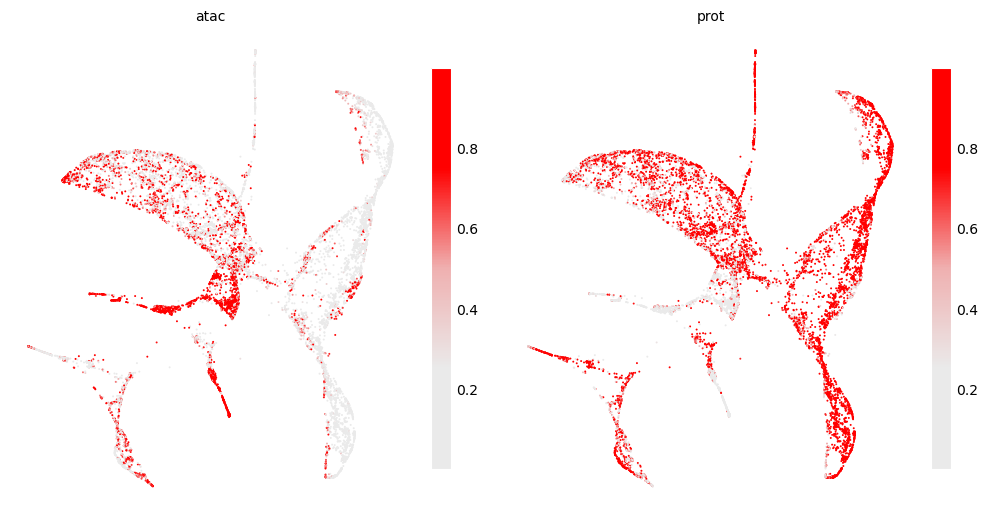

In [9]:
from matplotlib.colors import LinearSegmentedColormap

# define a colormap
cmap = LinearSegmentedColormap.from_list(
    'custom', ['#eaeaea', '#eaeaea', '#efb0b0', '#ff0000', '#ff0000'], N=256)

oci.pl.scatter(adata, x='X_fa2', c='weights', cmap=cmap, markersize=2, 
               fontsize=10, figsize=(10, 6))

## Investigating protein marker levels 

Protein markers are also an excellent tool for annotating cells. In this section, you will plot the normalized expression of selected markers.

Normalize the protein count matrix.

In [10]:
import scanpy as sc
import numpy as np

# define a colormap
cmap = LinearSegmentedColormap.from_list(
    'custom', ['#eaeaea', '#eaeaea', '#eaeaea', '#EFB0B0', '#FF0000', '#000000'], N=256)

# normalize the count matrix
sc.pp.normalize_total(prot, target_sum=10000)

### CD14 (CD14+ Monocytes)

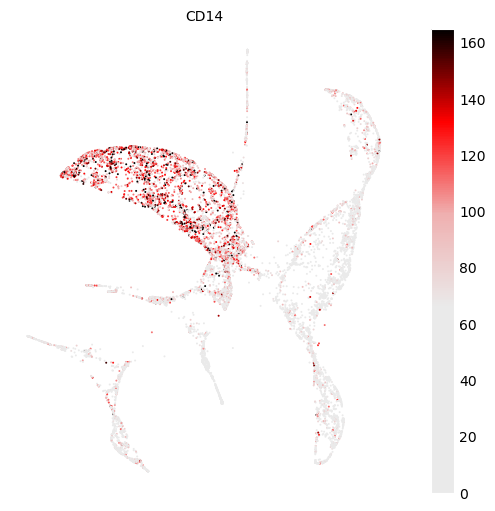

In [11]:
# specify a marker
marker = 'CD14'
# save normalized expression do adata.obs
adata.obs[marker] = prot[:, marker].X.toarray()
# plot normalized expression
oci.pl.scatter(adata, x='X_fa2', c=marker, cmap=cmap, markersize=2, 
               fontsize=10, vmax=np.percentile(adata.obs[marker], 98), 
               figsize=(8, 5))

### CD71 (Erythroid cells)

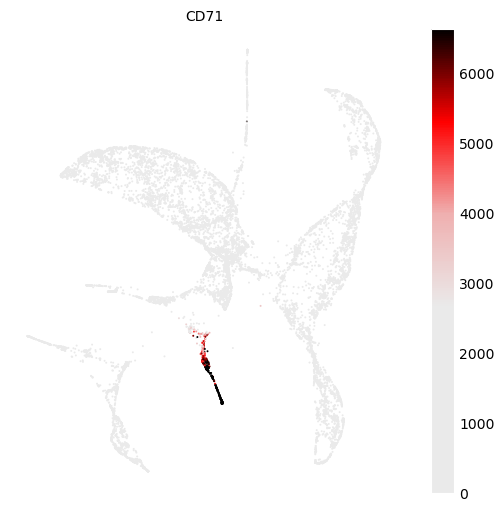

In [12]:
marker = 'CD71'
adata.obs[marker] = prot[:, marker].X.toarray()
oci.pl.scatter(adata, x='X_fa2', c=marker, cmap=cmap, markersize=2, 
               fontsize=10, vmax=np.percentile(adata.obs[marker], 98), 
               figsize=(8, 5))

### CD34 (Hematopoietic stem cells)

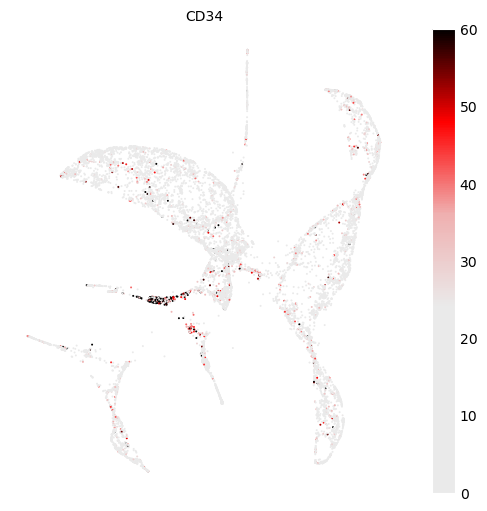

In [13]:
marker = 'CD34'
adata.obs[marker] = prot[:, marker].X.toarray()
oci.pl.scatter(adata, x='X_fa2', c=marker, cmap=cmap, markersize=2, 
               fontsize=10, vmax=np.percentile(adata.obs[marker], 98), 
               figsize=(8, 5))

### CD123 (Plasmacytoid dendritic cells)

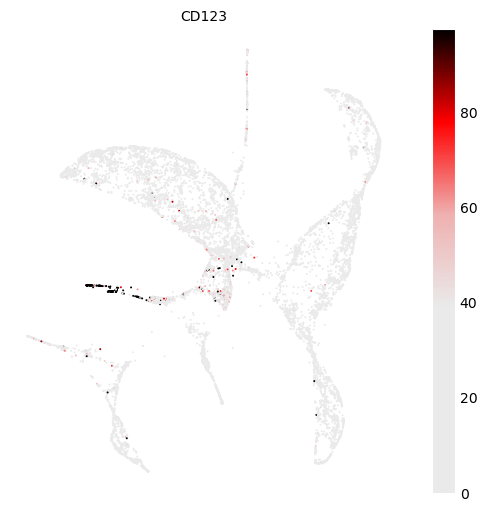

In [14]:
marker = 'CD123'
adata.obs[marker] = prot[:, marker].X.toarray()
oci.pl.scatter(adata, x='X_fa2', c=marker, cmap=cmap, markersize=2, 
               fontsize=10, vmax=np.percentile(adata.obs[marker], 98), 
               figsize=(8, 5))

### CD19 (B cells)

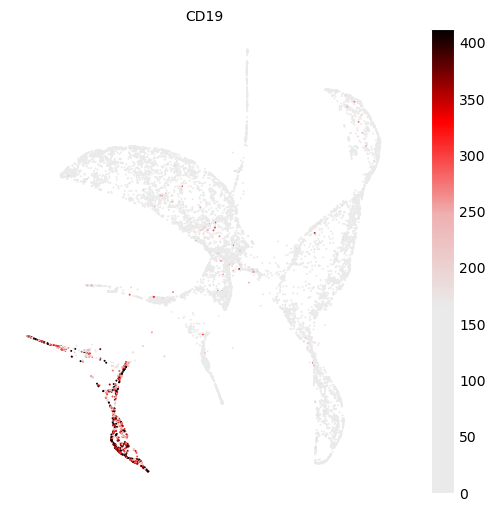

In [15]:
marker = 'CD19'
adata.obs[marker] = prot[:, marker].X.toarray()
oci.pl.scatter(adata, x='X_fa2', c=marker, cmap=cmap, markersize=2, 
               fontsize=10, vmax=np.percentile(adata.obs[marker], 98), 
               figsize=(8, 5))

### CD4 (CD4+ naive T cells)

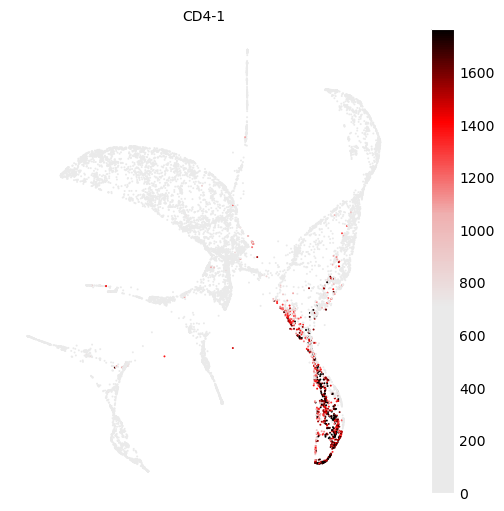

In [16]:
marker = 'CD4-1'
adata.obs[marker] = prot[:, marker].X.toarray()
oci.pl.scatter(adata, x='X_fa2', c=marker, cmap=cmap, markersize=2, 
               fontsize=10, vmax=np.percentile(adata.obs[marker], 98), 
               figsize=(8, 5))

### CD8 (CD8+ naive T cells)

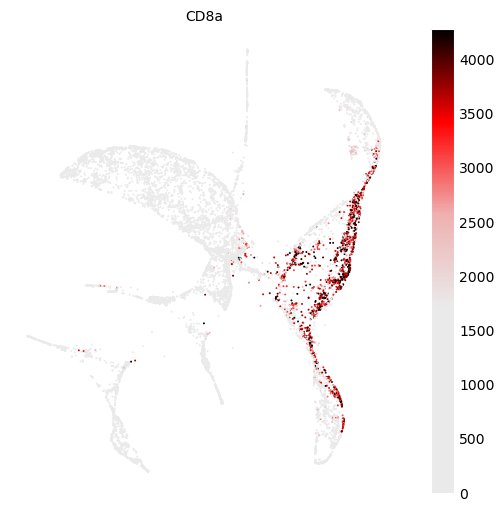

In [17]:
marker = 'CD8a'
adata.obs[marker] = prot[:, marker].X.toarray()
oci.pl.scatter(adata, x='X_fa2', c=marker, cmap=cmap, markersize=2, 
               fontsize=10, vmax=np.percentile(adata.obs[marker], 98), 
               figsize=(8, 5))

In Tutorial 5, you will use Ocelli's multimodal diffusion functionality to explore developmental subtrajectories originating in hematopoietic stem cells.